In [1]:
%matplotlib inline

import torch
from torch.nn import *

import torchvision
from torchvision.transforms import *

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from maintrainer.loss import YoloLoss
from model import YOLOv1
from maintrainer.dataset import VOCYOLOAnnotator, VOCYolo

In [2]:
annotator = VOCYOLOAnnotator(
    annotation_root=r'C:\Dataset\VOCdevkit\VOC2008\Annotations',
    image_root=r'C:\Dataset\VOCdevkit\VOC2008\JPEGImages'
)

annotations = annotator.parse_annotation()
print("Annotation[0]:", annotations[0][0])
print("Annotation[1]:", annotations[0][1])

Annotation 내 Object Names 검색:   0%|          | 0/5096 [00:00<?, ?it/s]

Annotation 검색:   0%|          | 0/5096 [00:00<?, ?it/s]

Annotation[0]: C:\Dataset\VOCdevkit\VOC2008\JPEGImages\2007_000027.jpg
Annotation[1]: [[14, 3, 3, 0.10949441504997065, 0.023428571428571465, 0.360082304526749, 0.5]]


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import IPython

from PIL import Image, ImageDraw
from random import randrange
from torchvision.ops import nms

def draw_cell_boundaries(image, cells=7):
    overlay = Image.new('RGBA', image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(image)
    overlay_draw = ImageDraw.Draw(overlay)
    image_width, image_height = image.size
    
    fill_color = (255, 255, 128, 200)
    
    unit = image_width / cells
    for idx in range(1, cells):
        vertical_line_x = unit * idx
        overlay_draw.line([(vertical_line_x, 0), (vertical_line_x, image_height)], fill=fill_color)

    unit = image_height / cells
    for idx in range(1, cells):
        horizontal_line_y = unit * idx
        overlay_draw.line([(0, horizontal_line_y), (image_width, horizontal_line_y)], fill=fill_color)
        
    return Image.alpha_composite(image.convert("RGBA"), overlay).convert("RGB")
        
def draw_center_cell_object(image, annotator, annotation, cells=7):
    draw = ImageDraw.Draw(image)
    image_width, image_height = image.size
    
    fill_color = (255, 0, 0, 255)
    
    for item in annotation:
        (class_id, cell_idx_x, cell_idx_y, cell_pos_x, cell_pos_y, width, height) = item
        overlay = Image.new('RGBA', image.size, (0, 0, 0, 0))
        overlay_draw = ImageDraw.Draw(overlay)

        horizontal_unit = image_width / cells
        vertical_unit = image_height / cells

        class_name = annotator.labels[class_id]

        # draw center cell as red color
        cxmin = horizontal_unit * cell_idx_x
        cxmax = horizontal_unit * (cell_idx_x + 1)
        cymin = vertical_unit * cell_idx_y
        cymax = vertical_unit * (cell_idx_y + 1)
        
        draw.line([(cxmin, cymin), (cxmax, cymin)], fill=fill_color)
        draw.line([(cxmax, cymin), (cxmax, cymax)], fill=fill_color)
        draw.line([(cxmax, cymax), (cxmin, cymax)], fill=fill_color)
        draw.line([(cxmin, cymax), (cxmin, cymin)], fill=fill_color)
        
        cell_obj_center_x = int(cxmin + (cell_pos_x * image_width))
        cell_obj_center_y = int(cymin + (cell_pos_y * image_height))
        
        oxmin, oxmax = int(cell_obj_center_x + (width * image_width / 2)), int(cell_obj_center_x - (width * image_width / 2))
        oymin, oymax = int(cell_obj_center_y + (height * image_height / 2)), int(cell_obj_center_y - (height * image_height / 2))
        
        draw.ellipse([(cell_obj_center_x - 3, cell_obj_center_y - 3), (cell_obj_center_x + 3, cell_obj_center_y + 3)], fill=(255, 0, 0), width=6)
        draw.text((cell_obj_center_x + 8, cell_obj_center_y - 6), "CLSID: %s" % class_name, fill=fill_color)
        
        random_color_r, random_color_g, random_color_b = randrange(255), randrange(255), randrange(255)
        overlay_color = (random_color_r, random_color_g, random_color_b, 90)
        overlay_draw.rectangle([oxmin, oymin, oxmax, oymax], fill=overlay_color)  # draw object in random color
        
        image = Image.alpha_composite(image.convert("RGBA"), overlay).convert("RGB")
        
    return image

def draw_center_cell_object_label(image, annotator, label):
    draw = ImageDraw.Draw(image)
    image_width, image_height = image.size
    
    fill_color = (255, 0, 0, 255)
    
    # label -> [25, 7, 7]
    cells = label.shape[1] # 1, 2 indicates cell count
    
    for cell_idx_y in range(cells):
        for cell_idx_x in range(cells):
            # ignore predictor with no bbox confidence
            if label[4, cell_idx_y, cell_idx_x] == 0:
                continue
                
            # (class_id, cell_idx_x, cell_idx_y, cell_pos_x, cell_pos_y, width, height) = item
            current_predictor = label[:, cell_idx_y, cell_idx_x]
            (cell_pos_x, cell_pos_y, width, height) = current_predictor[:4]
            class_id = np.argmax(current_predictor[5:])
            
            overlay = Image.new('RGBA', image.size, (0, 0, 0, 0))
            overlay_draw = ImageDraw.Draw(overlay)

            horizontal_unit = image_width / cells
            vertical_unit = image_height / cells

            class_name = annotator.labels[class_id]

            # draw center cell as red color
            cxmin = horizontal_unit * cell_idx_x
            cxmax = horizontal_unit * (cell_idx_x + 1)
            cymin = vertical_unit * cell_idx_y
            cymax = vertical_unit * (cell_idx_y + 1)

            draw.line([(cxmin, cymin), (cxmax, cymin)], fill=fill_color)
            draw.line([(cxmax, cymin), (cxmax, cymax)], fill=fill_color)
            draw.line([(cxmax, cymax), (cxmin, cymax)], fill=fill_color)
            draw.line([(cxmin, cymax), (cxmin, cymin)], fill=fill_color)

            cell_obj_center_x = int(cxmin + (cell_pos_x * image_width))
            cell_obj_center_y = int(cymin + (cell_pos_y * image_height))

            oxmin, oxmax = int(cell_obj_center_x + (width * image_width / 2)), int(cell_obj_center_x - (width * image_width / 2))
            oymin, oymax = int(cell_obj_center_y + (height * image_height / 2)), int(cell_obj_center_y - (height * image_height / 2))

            draw.ellipse([(cell_obj_center_x - 3, cell_obj_center_y - 3), (cell_obj_center_x + 3, cell_obj_center_y + 3)], fill=(255, 0, 0), width=6)
            draw.text((cell_obj_center_x + 8, cell_obj_center_y - 6), "CLSID: %s" % class_name, fill=fill_color)

            random_color_r, random_color_g, random_color_b = randrange(255), randrange(255), randrange(255)
            overlay_color = (random_color_r, random_color_g, random_color_b, 90)
            overlay_draw.rectangle([oxmin, oymin, oxmax, oymax], fill=overlay_color)  # draw object in random color

            image = Image.alpha_composite(image.convert("RGBA"), overlay).convert("RGB")
        
    return image

# TODO: redesign based on 2 predictor output
# ignore predictor with lower bbox confidence

# model output version of draw_center_cell_object
def draw_center_cell_object_output(image, annotator, output, confidence_threshold=0.3):
    draw = ImageDraw.Draw(image)
    image_width, image_height = image.size
    
    fill_color = (255, 0, 0, 255)
    
    # output -> [30, 7, 7]
    cells = output.shape[1] # 1, 2 indicates cell count
    bboxes = (output.shape[0] - 20) // 5
    assert((output.shape[0] - 20) % 5 == 0) 
    
    # Organize bboxes for NMS algorithm
    bbox_coordinates = []
    bbox_scores = []
    bbox_classes = []
    for cell_idx_y in range(cells):
        for cell_idx_x in range(cells):
            for bbox_idx in range(bboxes):
                current_predictor = output[5 * (bbox_idx):5 * (bbox_idx + 1), cell_idx_y, cell_idx_x]
                (cell_pos_x, cell_pos_y, width, height) = torch.sigmoid(torch.from_numpy(current_predictor[:4])).numpy()
                confidence = current_predictor[4]
                class_id = np.argmax(output[5 * bboxes:, cell_idx_y, cell_idx_x])
                
                if confidence < confidence_threshold:
                    continue

                horizontal_unit = image_width / cells
                vertical_unit = image_height / cells
                
                class_name = annotator.labels[class_id]
                obj_center_x = (cell_idx_x + cell_pos_x) / cells
                obj_center_y = (cell_idx_y + cell_pos_y) / cells
                oxmin, oxmax = obj_center_x - (width / 2), obj_center_x + (width / 2)
                oymin, oymax = obj_center_y - (height / 2), obj_center_y + (height / 2)
                
                bbox_coordinates.append([oxmin, oymin, oxmax, oymax])
                bbox_scores.append(confidence)
                bbox_classes.append(class_id)
                
    print("bbox_coordinates", bbox_coordinates)
    print("bbox_scores", bbox_scores)
    print("bbox_classes", bbox_classes)
                
    if len(bbox_coordinates) > 0:
        # print("[Before NMS] BBoxes:", len(bbox_coordinates))

        bbox_coordinates = torch.from_numpy(np.array(bbox_coordinates)).float()
        bbox_scores = torch.from_numpy(np.array(bbox_scores)).float()
        bbox_classes = torch.from_numpy(np.array(bbox_classes)).float()

        coordinates_indicies = nms(boxes=bbox_coordinates, scores=bbox_scores, iou_threshold=0.8)
        
#         bbox_filtered_coordinates = torch.gather(bbox_coordinates, 1, coordinates_indicies)
#         bbox_filtered_scores = torch.gather(bbox_scores, 0, coordinates_indicies)
#         bbox_filtered_classes = torch.gather(bbox_classes, 0, coordinates_indicies)

        bbox_filtered_coordinates = bbox_coordinates.index_select(0, coordinates_indicies)
        bbox_filtered_scores = bbox_scores.index_select(0, coordinates_indicies)
        bbox_filtered_classes = bbox_classes.index_select(0, coordinates_indicies).int()
        
        print("[After NMS] BBoxes:", len(bbox_filtered_coordinates))

        for idx in range(bbox_filtered_coordinates.shape[0]):
            (xmin, ymin, xmax, ymax) = bbox_filtered_coordinates[idx].numpy()
            confidence = bbox_filtered_scores[idx].numpy()
            class_id = bbox_filtered_classes[idx].numpy()
            
            oxmin, oxmax = max(xmin * image_width, 0), min(xmax * image_width, image_width - 1)
            oymin, oymax = max(ymin * image_height, 0), min(ymax * image_height, image_height - 1)
            
            cell_obj_center_x, cell_obj_center_y = int(oxmin + (oxmax - oxmin) / 2), int(oymin + (oymax - oymin) / 2)

            class_name = annotator.labels[class_id]

            overlay = Image.new('RGBA', image.size, (0, 0, 0, 0))
            overlay_draw = ImageDraw.Draw(overlay)

            draw.ellipse([(cell_obj_center_x - 3, cell_obj_center_y - 3), (cell_obj_center_x + 3, cell_obj_center_y + 3)], fill=(255, 0, 0), width=6)
            
            draw.text((cell_obj_center_x + 8, cell_obj_center_y - 6), "CLSID: %s" % class_name, fill=fill_color)

            random_color_r, random_color_g, random_color_b = randrange(255), randrange(255), randrange(255)
            overlay_color = (random_color_r, random_color_g, random_color_b, 90)
            overlay_draw.rectangle([oxmin, oymin, oxmax, oymax], fill=overlay_color)  # draw object in random color

            image = Image.alpha_composite(image.convert("RGBA"), overlay).convert("RGB")
        
    return image


In [4]:
import torchvision.transforms
from torchvision.transforms import *

train_dataset = VOCYolo(
    annotator.labels,
    annotations,
    transform=transforms.Compose([
        transforms.Resize((448, 448)),
        transforms.ToTensor(),
#         transforms.Normalize(
#             mean=[0.4547857, 0.4349471, 0.40525291],
#             std=[0.12003352, 0.12323549, 0.1392444]
#         )
    ])
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=False, batch_size=1, num_workers=0, pin_memory=True)

model = YOLOv1().float().cuda()

criterion = YoloLoss(lambda_coord=5, lambda_noobj=0.5)
scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.Adam(model.parameters())

bunch_of_batch = []
for i, item in enumerate(train_dataloader):
    if i >= 4:
        break
    bunch_of_batch.append(item)

NewYoloLossV6 (CUDA not supported for now)


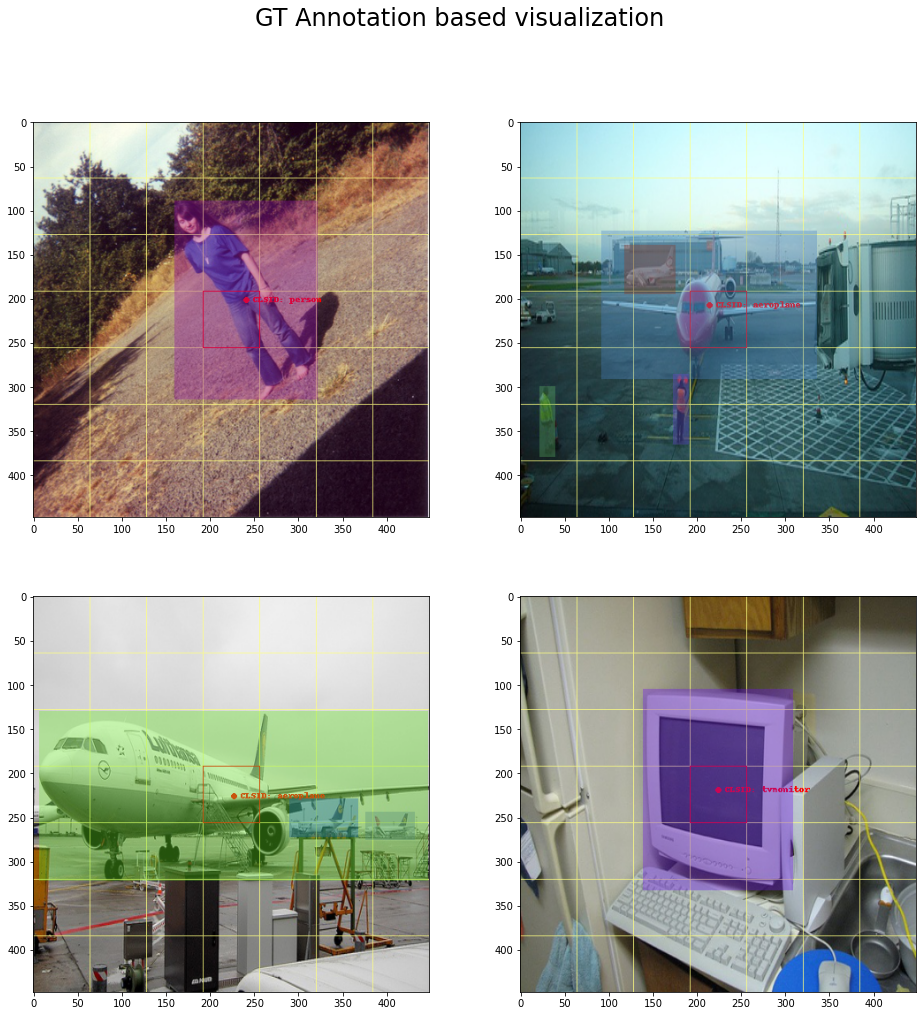

In [5]:
fig = plt.figure(figsize=(16, 16))
fig.suptitle("GT Annotation based visualization", fontsize=24)
for i, (image, label) in enumerate(bunch_of_batch):
    ax = fig.add_subplot(2, 2, i + 1)
    image = torch.squeeze(image)
    label = torch.squeeze(label)
    
    image = (image.numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
    label = label.numpy()
    
    image = Image.fromarray(image)
    image = draw_cell_boundaries(image)
    image = draw_center_cell_object(image, annotator, annotations[i][1])
    ax.imshow(np.array(image))

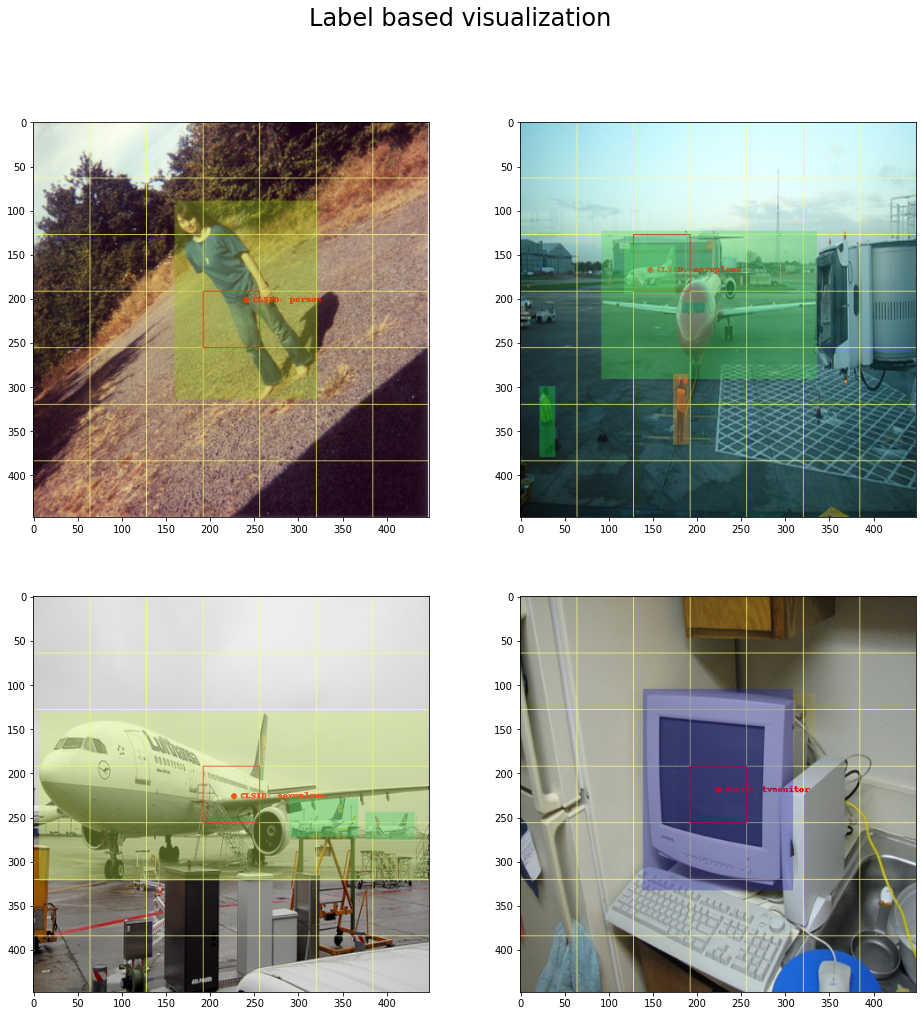

In [6]:
fig = plt.figure(figsize=(16, 16))
fig.suptitle("Label based visualization", fontsize=24)
for i, (image, label) in enumerate(bunch_of_batch):
    ax = fig.add_subplot(2, 2, i + 1)
    image = torch.squeeze(image)
    label = torch.squeeze(label)
    
    image = (image.numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
    label = label.numpy()
    
    image = Image.fromarray(image)
    image = draw_cell_boundaries(image)
    image = draw_center_cell_object_label(image, annotator, label)
    ax.imshow(np.array(image))
    
plt.show()

bbox_coordinates []
bbox_scores []
bbox_classes []
bbox_coordinates []
bbox_scores []
bbox_classes []
bbox_coordinates []
bbox_scores []
bbox_classes []
bbox_coordinates []
bbox_scores []
bbox_classes []


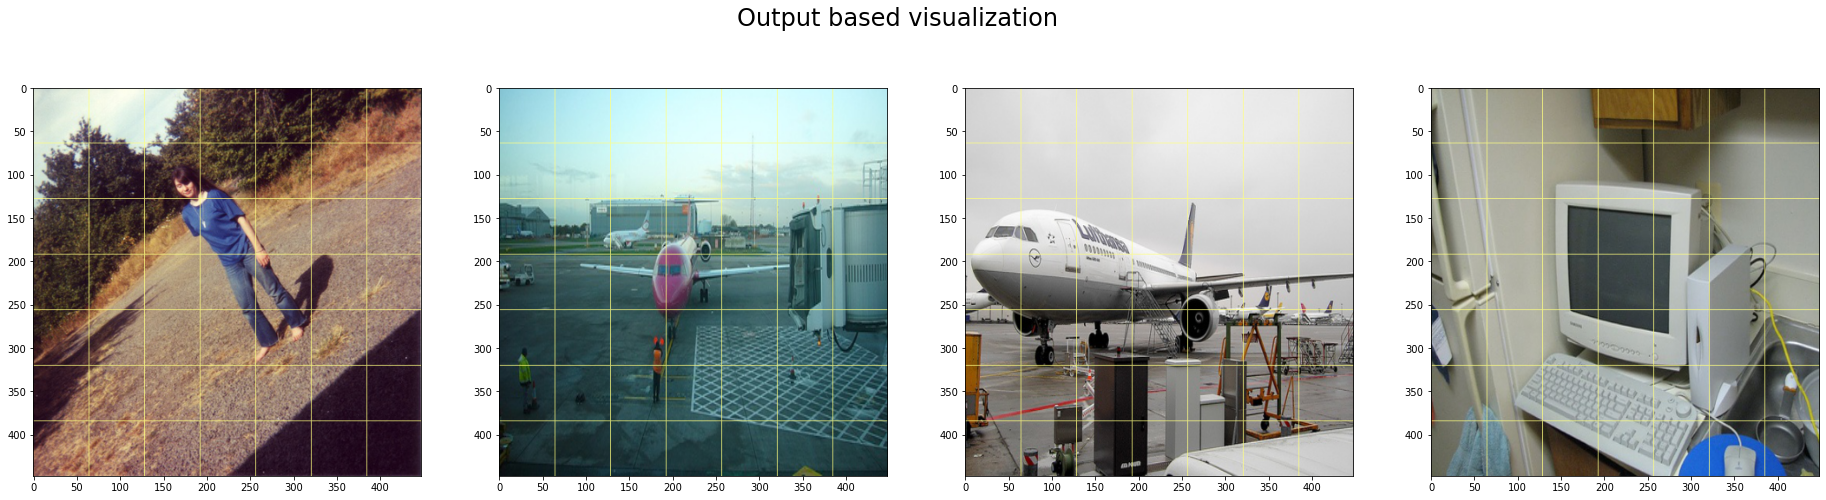

In [7]:
def do_visualization(title = None):
    fig = plt.figure(figsize=(32, 8))
    fig.suptitle("Output based visualization" if title is None else title, fontsize=24)
    
    model.eval()
    for i, (image, label) in enumerate(bunch_of_batch):
        ax = fig.add_subplot(1, 4, i + 1)

        output = model(image.cuda()).detach().cpu()

        image = torch.squeeze(image.cpu())
        output = torch.squeeze(output)

        image = (image.numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
        output = output.numpy()

        image = Image.fromarray(image)
        image = draw_cell_boundaries(image)
        image = draw_center_cell_object_output(image, annotator, output, confidence_threshold=0.51)
        ax.imshow(np.array(image))
    model.train()

    plt.show()
    
do_visualization()

bbox_coordinates [[0.10000035166740417, 0.19999942183494568, 0.8999996483325958, 0.8000005781650543]]
bbox_scores [0.6]
bbox_classes [5]
[After NMS] BBoxes: 1
bbox_coordinates [[0.10000035166740417, 0.19999942183494568, 0.8999996483325958, 0.8000005781650543]]
bbox_scores [0.6]
bbox_classes [5]
[After NMS] BBoxes: 1
bbox_coordinates [[0.10000035166740417, 0.19999942183494568, 0.8999996483325958, 0.8000005781650543]]
bbox_scores [0.6]
bbox_classes [5]
[After NMS] BBoxes: 1
bbox_coordinates [[0.10000035166740417, 0.19999942183494568, 0.8999996483325958, 0.8000005781650543]]
bbox_scores [0.6]
bbox_classes [5]
[After NMS] BBoxes: 1


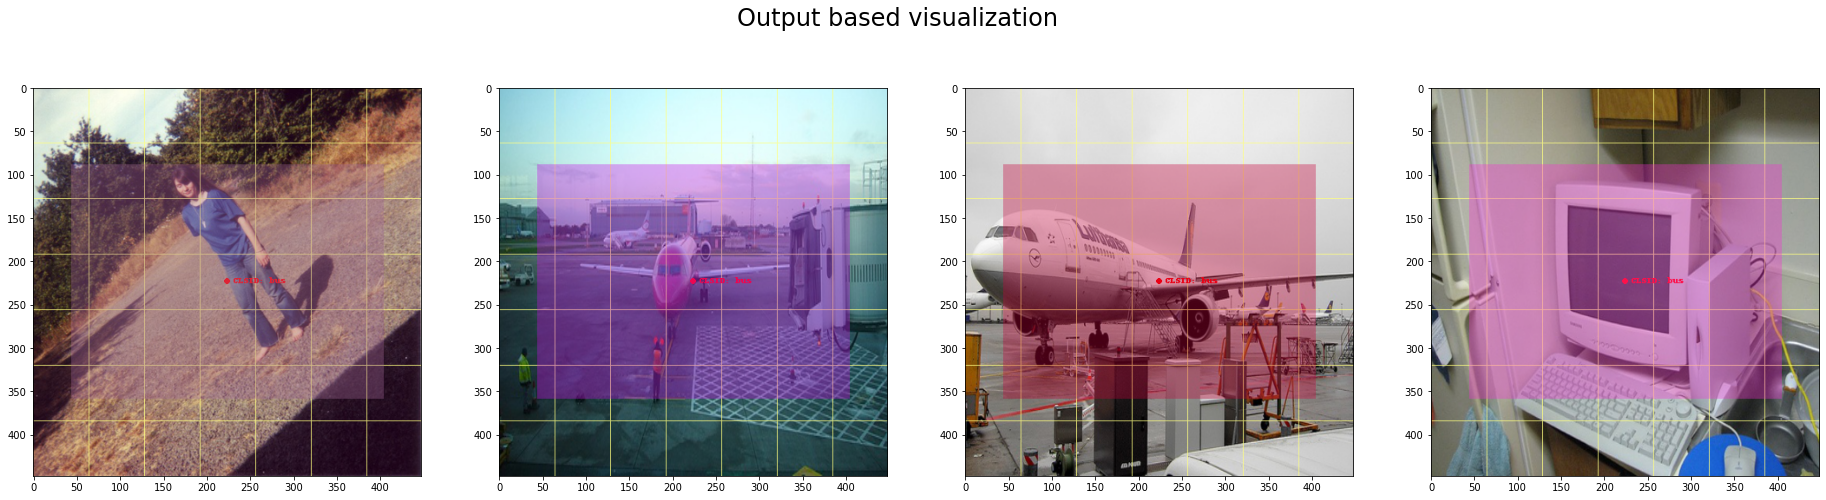

In [8]:
# Testing over pseudo-output

def do_visualization_pseudo(title = None):
    fig = plt.figure(figsize=(32, 8))
    fig.suptitle("Output based visualization" if title is None else title, fontsize=24)
    
    model.eval()
    for i, (image, label) in enumerate(bunch_of_batch):
        ax = fig.add_subplot(1, 4, i + 1)
        output = torch.zeros((1, 30, 7, 7))
        # Adds object inside center point (3, 3)
        output[0, :, 3, 3] = torch.from_numpy(np.array([
            #x, y, w, h, c, classes
            0.0, 0.0, 1.38629, 0.40547, 0.6, # 0.5, 0.5, 0.8, 0.6, 0.6,
            -2.197224, 2.197225, -0.405465, -1.3862894, 0.1, # 0.1, 0.9, 0.4, 0.2, 0.1,
            0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
        ]))

        image = torch.squeeze(image.cpu())
        output = torch.squeeze(output)

        image = (image.numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
        output = output.numpy()

        image = Image.fromarray(image)
        image = draw_cell_boundaries(image)
        image = draw_center_cell_object_output(image, annotator, output, confidence_threshold=0.51)
        ax.imshow(np.array(image))
    model.train()

    plt.show()

do_visualization_pseudo()